In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import sklearn

from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn import FunctionSampler  # to use a idendity sampler

from pandas.api.types import CategoricalDtype

In [2]:
np.random.seed(0)
IMPUTATION_REQUIRED=0
TRAIN_SIZE=1
PAR_NORMALIZE=0
PAR_SCALE=1
target_col = 'lrgen' # 'lrgen', 'lrecon', 'galtan'
target_factor = target_col + '_factor' # 'lrgen_factor', 'lrecon_factor', 'galtan_factor'
SOURCE_DATA_FILES = 'data/base_data/recategorized/' #imputation_cart/'
FILE_SUFFIX = '_recategorized'

In [3]:
#data_raw = pd.read_csv("data/CHES2019_experts_imputed_cart.csv", index_col=0).reset_index(drop=True)
data_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_train' + FILE_SUFFIX + '.csv', index_col = 0)
data_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_train' + FILE_SUFFIX + '.csv', index_col = 0)
#valid_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_valid' + FILE_SUFFIX + '.csv', index_col = 0)
#valid_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_valid' + FILE_SUFFIX + '.csv', index_col = 0)
test_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_test' + FILE_SUFFIX + '.csv', index_col = 0)
test_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_test' + FILE_SUFFIX + '.csv', index_col = 0)
#data = pd.read_csv("data/CHES2019_experts_imputed_pmm.csv")

In [4]:
data_X

,econ_interven,environment,redistribution,civlib_laworder,immigrate_policy,sociallifestyle
2529,9.0,7.0,9.0,2.0,6.0,1.0
864,7.0,7.0,5.0,6.0,7.0,8.0
1386,0.0,5.0,2.0,7.0,3.0,9.0
3554,9.0,8.0,9.0,9.0,10.0,8.0
1058,6.0,8.0,7.0,4.0,7.0,7.0
...,...,...,...,...,...,...
2141,10.0,8.0,10.0,2.0,7.0,2.0
533,1.0,5.0,0.0,4.0,3.0,0.0
2549,3.0,7.0,4.0,4.0,4.0,4.0
3392,8.0,6.0,6.0,8.0,6.0,2.0


In [5]:
# combination allowed
#data_X = data_X.concat(valid_X)
#data_y = data_y.concat(valid_y)

In [6]:
data_raw = data_X.merge(data_y, left_on = data_X.index, right_on = data_y.index, how = 'right').set_index('key_0')

In [7]:
data_raw

,econ_interven,environment,redistribution,civlib_laworder,immigrate_policy,sociallifestyle,lrgen_factor
key_0,,,,,,,
2529,9.0,7.0,9.0,2.0,6.0,1.0,c
864,7.0,7.0,5.0,6.0,7.0,8.0,r
1386,0.0,5.0,2.0,7.0,3.0,9.0,c
3554,9.0,8.0,9.0,9.0,10.0,8.0,r
1058,6.0,8.0,7.0,4.0,7.0,7.0,c
...,...,...,...,...,...,...,...
2141,10.0,8.0,10.0,2.0,7.0,2.0,r
533,1.0,5.0,0.0,4.0,3.0,0.0,c
2549,3.0,7.0,4.0,4.0,4.0,4.0,c


In [8]:
# imputation and preprocessing (if required)
#if (IMPUTATION_REQUIRED==1):
#    numeric_features = data.columns.values[0:6]
#    numeric_transformer = Pipeline(steps=[
#        ("imputer", SimpleImputer(strategy="mean")),
#        ("scaler", StandardScaler())
#    ])
#
#    categorical_features = ["lrgen_factor", "lrecon_factor", "galtan_factor"]
#    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
#
#    preprocessor = ColumnTransformer(transformers=[
#        ("num_transform", numeric_transformer, numeric_features),
#        ("cat_transform", categorical_transformer, categorical_features)
#    ])


In [9]:
data_raw.describe()

,econ_interven,environment,redistribution,civlib_laworder,immigrate_policy,sociallifestyle
count,2593.000000,2593.000000,2593.000000,2593.000000,2593.000000,2593.000000
mean,4.573853,5.212495,4.440417,5.054377,5.570767,4.288855
std,2.652167,2.625398,2.539734,2.911194,2.902297,3.227883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000
50%,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000
75%,7.000000,7.000000,6.000000,7.000000,8.000000,7.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [10]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2593 entries, 2529 to 1614
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   econ_interven     2593 non-null   float64
 1   environment       2593 non-null   float64
 2   redistribution    2593 non-null   float64
 3   civlib_laworder   2593 non-null   float64
 4   immigrate_policy  2593 non-null   float64
 5   sociallifestyle   2593 non-null   float64
 6   lrgen_factor      2593 non-null   object 
dtypes: float64(6), object(1)
memory usage: 162.1+ KB


# Data preprocessing
Preprocessing steps (after imputation in R)

In [11]:
# split data into training and test dataset
# split data for obtaining a separated TEST dataset (not used for training)
X, y = data_raw[data_raw.columns.values[0:6]], data_raw[data_raw.columns.values[6]]
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=TRAIN_SIZE)
X_train = X
y_train = y

In [12]:
# standardization/normalization of data
# Be aware: information related to scaling MUST NOT flow into the separated datasets
# --> 1st split, 2nd scaling
if (PAR_NORMALIZE==1):
    data_normalized = preprocessing.normalize(X_train)

if (PAR_SCALE==1):
    scaler = preprocessing.StandardScaler().fit(X_train)
    data_scaled = scaler.transform(X_train)

In [13]:
X_train_base = X_train
y_train_base = y_train

# Oversampling to balance the dataset regarding target variable

In [14]:
#samplers = [
#    FunctionSampler(),
#    RandomOverSampler(random_state=0),
#    SMOTE(random_state=0),
#    ADASYN(random_state=0),
#]


#X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train_base, y_train_base)
X_train, y_train = SMOTE(random_state=0, sampling_strategy='not majority').fit_resample(X_train_base, y_train_base)
#X_train, y_train = ADASYN(random_state=0, sampling_strategy='minority').fit_resample(X_train_base, y_train_base)


#for sampler in samplers:
#    sampler.fit_resample(X_train, y_train)




In [15]:
y_train.value_counts()

c    1244
r    1244
l    1244
Name: lrgen_factor, dtype: int64

In [16]:
X_train

,econ_interven,environment,redistribution,civlib_laworder,immigrate_policy,sociallifestyle
0,9.000000,7.000000,9.000000,2.000000,6.000000,1.000000
1,7.000000,7.000000,5.000000,6.000000,7.000000,8.000000
2,0.000000,5.000000,2.000000,7.000000,3.000000,9.000000
3,9.000000,8.000000,9.000000,9.000000,10.000000,8.000000
4,6.000000,8.000000,7.000000,4.000000,7.000000,7.000000
...,...,...,...,...,...,...
3727,3.147686,1.295371,3.147686,9.704629,10.000000,10.000000
3728,9.000000,7.062636,7.937364,9.000000,8.000000,9.937364
3729,7.241902,8.000000,7.241902,10.000000,10.000000,10.000000
3730,6.432281,9.135437,7.000000,6.000000,9.135437,6.000000


# Principal Component Analysis: reduce dimensionality

In [17]:
# create a PCA with 2 components
# combine the result with the target result
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 
                                        'PC2'],
                          index=X_train.index)
finalDf = pd.concat([principalDf, y_train], axis = 1)


In [18]:
finalDf[target_factor].factorize()[0]

array([0, 1, 0, ..., 1, 1, 1])

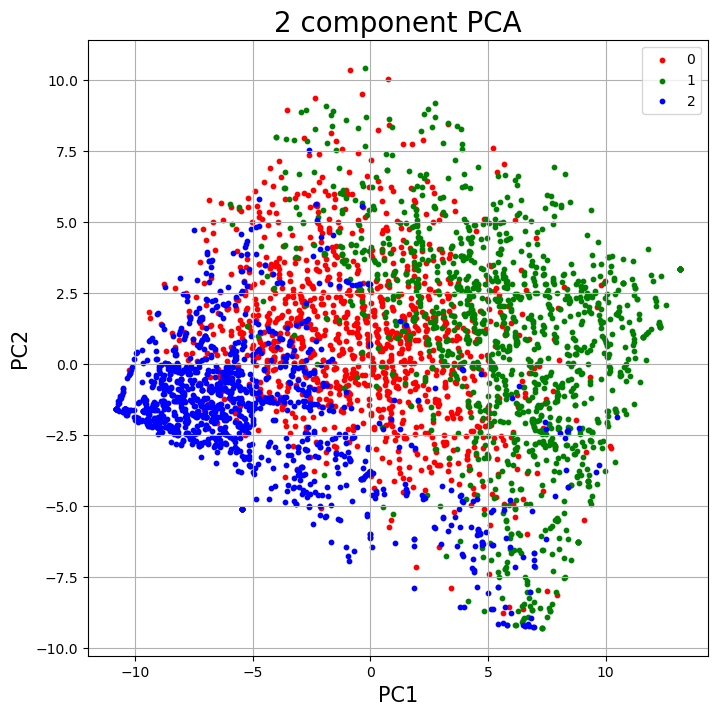

In [19]:
# visualize the results of the PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = range(0,3)
colors = ['r', 'g', 'b']#, 'c',  'm',  'y',  'k',  'gray',  'lime',  'orange',  'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[target_factor].factorize()[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

In [20]:
# about 80% of the variance are explained through the 2 components
pca.explained_variance_ratio_

array([0.63678313, 0.19192458])

# Clustering
Check if some patterns can be observed using unsupervised learning

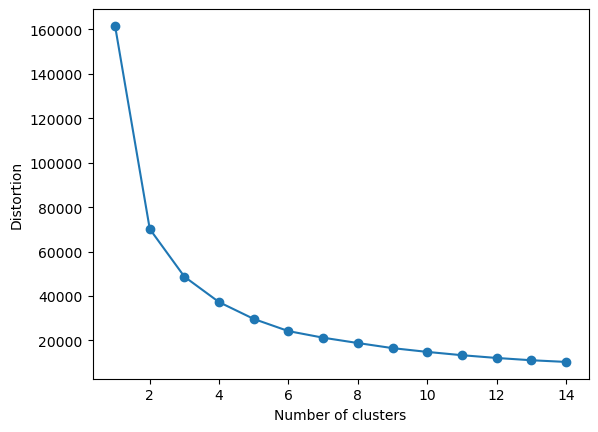

In [21]:
# try to obtain best number of clusters through scree plot
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(finalDf[['PC1', 'PC2']])
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [22]:
# try to cluster results of PCA
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(finalDf[['PC1', 'PC2']])

In [23]:
y_km

array([2, 1, 1, ..., 1, 1, 1], dtype=int32)

In [24]:
cluster_data = pd.concat([finalDf, 
                          pd.DataFrame(y_km, 
                                       index=X_train.index, 
                                       columns=['cluster'])], 
                         axis=1)

In [25]:
cluster_data.head(20)
#cluster_data[cluster_data['lrgen_factor']==10]['cluster'].value_counts()

,PC1,PC2,lrgen_factor,cluster
0,1.388267,7.752672,c,2
1,5.368785,0.593754,r,1
2,0.798426,-5.745984,c,1
3,10.364156,3.030932,r,1
4,4.664790,1.860763,c,2
5,-5.579732,-0.817654,l,0
6,7.865907,-1.347527,r,1
7,4.158885,4.435575,r,2
8,4.204970,2.516916,r,2
9,-3.421868,-2.443914,c,0


# Supervised learning: various algorithms
### Sources: https://vitalflux.com/grid-search-explained-python-sklearn-examples/

## 1) Support Vector Classification

CHECK: RMSE and other scoring mechanisms

In [26]:
########### PARAMETERS 
scoring_method = 'balanced_accuracy'#['balanced_accuracy', 'f1_samples', 'roc_auc_ovo_weighted']

In [27]:
# CROSS-VALIDATION (without TEST dataset)

clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.75502008 0.74966533 0.78150134 0.76809651 0.75067024]
0.76 accuracy with a standard deviation of 0.01


In [28]:
pipelineSVC = make_pipeline(StandardScaler(), SVC(random_state=1))
# Create the parameter grid
param_grid_svc = [{
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['linear'],
                    'svc__degree': [1,2,3,4,5]
                  },
                 {
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['rbf']
                 }]
# Create an instance of GridSearch Cross-validation estimator
gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring=scoring_method,
                     cv=10,
                     refit=True,
                     n_jobs=1)
# Train the SVM classifier
gsSVC.fit(X_train, y_train)
# Print the training score of the best model
print(gsSVC.best_score_)
# Print the model parameters of the best model
print(gsSVC.best_params_)
# Print the model score on the test data using GridSearchCV score method
print('Test accuracy: %.3f' % gsSVC.score(test_X, test_y))
# Print the model score on the test data using Best estimator instance
clfSVC = gsSVC.best_estimator_
print('Test accuracy: %.3f' % clfSVC.score(test_X, test_y))

0.8204967741935484
{'svc__C': 10.0, 'svc__gamma': 10.0, 'svc__kernel': 'rbf'}
Test accuracy: 0.632
Test accuracy: 0.682


## Random Forest Classification

In [29]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1, criterion='entropy')) 
# Create the parameter grid
                            
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6],
    'randomforestclassifier__n_estimators':range(5, 105, 5)#,
    #'randomforestclassifier__criterion:':['gini', 'entropy']
}]
# Create an instance of GridSearch Cross-validation estimator
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring=scoring_method,
                     cv=10,
                     refit=True,
                     n_jobs=1)
# Train the RandomForestClassifier
gsRFC = gsRFC.fit(X_train, y_train)
# Print the training score of the best model
print(gsRFC.best_score_)
# Print the model parameters of the best model
print(gsRFC.best_params_)
# Print the test score of the best model
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(test_X, test_y))

0.8282602150537635
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__n_estimators': 70}
Test accuracy: 0.810


In [30]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

## Logistic Regression Classification

In [31]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
# Create the parameter grid
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
# Create an instance of GridSearch Cross-validation estimator
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring=scoring_method,
                     cv=10,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsLR = gsLR.fit(X_train, y_train)
# Print the training score of the best model
print(gsLR.best_score_)
# Print the model parameters of the best model
print(gsLR.best_params_)
# Print the test score of the best model
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(test_X, test_y))

0.7588301075268817
{'logisticregression__C': 0.01}
Test accuracy: 0.772


## ADABoost Classification (Ensemble Method)

In [32]:
pipelineADAB = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))
# Create the parameter grid
param_grid_ADAB = [{
    'adaboostclassifier__n_estimators': [2, 10, 20, 30, 40, 50, 100]
}]
# Create an instance of GridSearch Cross-validation estimator
gsADAB = GridSearchCV(estimator=pipelineADAB,
                     param_grid = param_grid_ADAB,
                     scoring=scoring_method,
                     cv=10,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsADAB = gsADAB.fit(X_train, y_train)
# Print the training score of the best model
print(gsADAB.best_score_)
# Print the model parameters of the best model
print(gsADAB.best_params_)
# Print the test score of the best model
clfADAB = gsADAB.best_estimator_
print('Test accuracy: %.3f' % clfADAB.score(test_X, test_y))

0.7724881720430108
{'adaboostclassifier__n_estimators': 100}
Test accuracy: 0.744


In [33]:
gsADAB.scoring

'balanced_accuracy'

# Test models with independent dataset

In [34]:
#scaler = preprocessing.StandardScaler().fit(test_X)
#test_X_scaled = scaler.transform(test_X)

In [35]:
sklearn.metrics.accuracy_score(test_y, gsADAB.predict(test_X))

0.7439446366782007

In [36]:
sklearn.metrics.confusion_matrix(test_y, gsADAB.predict(test_X))

array([[78, 23, 34],
       [ 4, 47,  3],
       [10,  0, 90]])

In [37]:
#sklearn.metrics.mean_squared_error(test_y, gsADAB.predict(test_X))

In [38]:
sklearn.metrics.f1_score(test_y, gsADAB.predict(test_X), average='weighted')

0.737044873537943

In [39]:
sklearn.metrics.accuracy_score(test_y, gsLR.predict(test_X))

0.7716262975778547

In [40]:
sklearn.metrics.confusion_matrix(test_y, gsLR.predict(test_X))

array([[84, 24, 27],
       [ 3, 50,  1],
       [10,  1, 89]])

In [41]:
sklearn.metrics.f1_score(test_y, gsLR.predict(test_X), average='weighted')

0.7669437217146002

In [42]:
sklearn.metrics.accuracy_score(test_y, gsRFC.predict(test_X))

0.8096885813148789

In [43]:
sklearn.metrics.confusion_matrix(test_y, gsRFC.predict(test_X))

array([[105,  13,  17],
       [ 10,  43,   1],
       [ 14,   0,  86]])

In [44]:
sklearn.metrics.f1_score(test_y, gsRFC.predict(test_X), average='weighted')

0.8094057818157147

In [45]:
sklearn.metrics.accuracy_score(test_y, gsSVC.predict(test_X))

0.6816608996539792

In [46]:
sklearn.metrics.confusion_matrix(test_y, gsSVC.predict(test_X))

array([[121,   5,   9],
       [ 25,  28,   1],
       [ 52,   0,  48]])

In [47]:
sklearn.metrics.f1_score(test_y, gsSVC.predict(test_X), average='weighted')

0.6699869289572642

In [48]:
#pipeline = Pipeline(steps=[("preprocesser", preprocessor), ("classifier", LogisticRegression())])
#pipeline.fit(X_train, y_train)

In [49]:
#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [50]:
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
#pipe.fit(X_train, y_train)
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
#pipe.score(X_test, y_test)

In [51]:
### Write several scores to the output ###

RMSE = False
model_vector = [gsADAB, gsLR, gsRFC, gsSVC]
for model in model_vector:
    print(model.estimator.named_steps)
    print('Accuracy Score: ', sklearn.metrics.accuracy_score(test_y, model.predict(test_X)))
    print('Balanced Accuracy Score: ', sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))
    print('Cohen-Kappa-Score: ', sklearn.metrics.cohen_kappa_score(test_y, model.predict(test_X)))
    print('F1-Score: ', sklearn.metrics.f1_score(test_y, model.predict(test_X), average='weighted'))
    if RMSE == True:
        print('RMSE: ', sklearn.metrics.mean_squared_error(test_y, model.predict(test_X)))
        #print('ROC-AUC-Score: ', sklearn.metrics.roc_auc_score(test_y, 
        #                                                       model.predict(test_X), 
        #                                                       average='weighted', 
        #                                                       multi_class='ovo'))
    print('__________________________________\n')

for model in model_vector:
    print('Confusion matrix: \n', sklearn.metrics.confusion_matrix(test_y, model.predict(test_X)))

for model in model_vector:
    print(sklearn.metrics.classification_report(test_y, model.predict(test_X)))

{'standardscaler': StandardScaler(), 'adaboostclassifier': AdaBoostClassifier(random_state=1)}
Accuracy Score:  0.7439446366782007
Balanced Accuracy Score:  0.782716049382716
Cohen-Kappa-Score:  0.6084656084656085
F1-Score:  0.737044873537943
__________________________________

{'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(random_state=1)}
Accuracy Score:  0.7716262975778547
Balanced Accuracy Score:  0.8127160493827161
Cohen-Kappa-Score:  0.6511449264759676
F1-Score:  0.7669437217146002
__________________________________

{'standardscaler': StandardScaler(), 'randomforestclassifier': RandomForestClassifier(criterion='entropy', random_state=1)}
Accuracy Score:  0.8096885813148789
Balanced Accuracy Score:  0.811358024691358
Cohen-Kappa-Score:  0.6982840438859572
F1-Score:  0.8094057818157147
__________________________________

{'standardscaler': StandardScaler(), 'svc': SVC(random_state=1)}
Accuracy Score:  0.6816608996539792
Balanced Accuracy Score:  0.63

In [52]:
print('Features:           ', gsRFC.feature_names_in_)
print('Feature Importance: ', gsRFC.best_estimator_[1].feature_importances_)

Features:            ['econ_interven' 'environment' 'redistribution' 'civlib_laworder'
 'immigrate_policy' 'sociallifestyle']
Feature Importance:  [0.24205166 0.08805132 0.2568246  0.16859947 0.15643245 0.0880405 ]


In [53]:
print('Features:           ', gsRFC.feature_names_in_)
print('Feature Importance: ', gsRFC.best_estimator_[1].feature_importances_)

Features:            ['econ_interven' 'environment' 'redistribution' 'civlib_laworder'
 'immigrate_policy' 'sociallifestyle']
Feature Importance:  [0.24205166 0.08805132 0.2568246  0.16859947 0.15643245 0.0880405 ]


In [55]:
from joblib import dump, load
dump(gsRFC, 'models/gsRFC_lrgen_reducedtarget_NoImputationData_353.joblib') 
#clf = load('filename.joblib')


['models/gsRFC_lrgen_reducedtarget_NoImputationData_353.joblib']